# 11/12/19

Finally got something working. This is a visualization of a model trained from scratch. We see the spread of the subclasses, thanks to whoever wrote the analysis_util functions ahead of me.

Insights:
1. Densenet sees some spread across the CIFAR subclasses
2. Densenet does decently well on CIFAR100 with coarse classes

Next Steps:
1. Train a model that uses LMCL as an auxiliary task on the penultimate layer.
2. Compare the predictions made on LMCL model with this model.

In [78]:
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import json
import pickle

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

import models.cifar as models
from analysis.analysis_utils import load_trained_model, fetch_dataloaders, get_coarse_accuracies

os.chdir('/lfs/1/gangus/repositories/pytorch-classification')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
experiment_paths = {
    'super': 'experiments/CIFAR100/superclass/12/'
}

experiment_configs = {}
for exp_name, exp_path in experiment_paths.items():
    with open(osp.join(exp_path, 'config.json')) as f:
        experiment_configs[exp_name] = json.load(f)

In [38]:
config = experiment_configs['super']

superclass = config['superclass']
cifar_type = config['cifar_type']
model_name = config['model_name']
model_args = config['model_args']
checkpoint_dir = config['checkpoint_dir']
trained_model = load_trained_model(cifar_type, model_name, model_args, checkpoint_dir)

data_dir = config['data_dir']
dataset_configs = config['dataset_configs']
dataloader_configs = config['dataloader_configs']
dataloaders = fetch_dataloaders(data_dir, cifar_type, superclass, dataset_configs, dataloader_configs)

# Getting class-to-index maps for CIFAR100
class_to_idx = {}
class_to_idx['super'] = dataloaders['test'].dataset.class_to_idx
class_to_idx['sub'] = dataloaders['test'].dataset.fine_class_to_idx

idx_to_class = {}
for tp in ['super', 'sub']:
    idx_to_class[tp] = {v:k for k, v in class_to_idx[tp].items()}
    
trained_model = trained_model.to('cpu')
trained_model = trained_model.module.to('cpu')

Using 20 classes...
Using coarse labels...
Using coarse labels...


In [52]:
filenames_all = []
coarse_labels_all = []
fine_labels_all = []
fine_preds_all = []
preds_all = []
losses_all = []
softmax_all = []
features_all = []

t = tqdm(total=len(dataloaders['test']))
for batch_idx, (inputs, 
                targets, 
                coarse_labels, 
                fine_labels, 
                filenames) in enumerate(dataloaders['test']):
    
    inputs, targets = inputs.cpu(), targets.cpu()
    inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
    
    outputs = trained_model(inputs)
    _, preds = outputs.topk(1, 1, True, True)
    soft = torch.nn.Softmax(dim=-1)(outputs)
    # feats = extract_resnext_features(trained_model,inputs)
    
    coarse_labels_all+=list([int(a) for a in coarse_labels])
    fine_labels_all+=list([int(a) for a in fine_labels])
    preds_all+=list([int(a) for a in preds])
    softmax_all+=list([a.detach().cpu().numpy() for a in soft])
    # features_all+=list([a.detach().cpu().numpy() for a in feats])
    filenames_all+=list(filenames)
    t.update()
t.close()

In [66]:
preds_dict = {
    'filename':filenames_all,
    'fine_labels':fine_labels_all,
    'coarse_labels':coarse_labels_all,
    'preds':preds_all,
    'fine_labels_string': [idx_to_class['sub'][a] for a in fine_labels_all],
    'coarse_labels_string': [idx_to_class['super'][a] for a in coarse_labels_all],
    # 'features':features_all,
    'softmax':softmax_all,
}
with open(f"{checkpoint_dir}/predictions.pkl",'wb') as f:
   pickle.dump(preds_dict, f)

prediction_df = pd.DataFrame(preds_dict)

In [71]:
coarse_results = get_coarse_accuracies(prediction_df)

coarse label accuracy: 0.89 	 (superclass: large_natural_outdoor_scenes)
--
coarse label accuracy: 0.86	 (subclass: mountain)
coarse label accuracy: 0.79	 (subclass: forest)
coarse label accuracy: 0.94	 (subclass: sea)
coarse label accuracy: 0.91	 (subclass: cloud)
coarse label accuracy: 0.95	 (subclass: plain)
==

coarse label accuracy: 0.714 	 (superclass: aquatic_mammals)
--
coarse label accuracy: 0.69	 (subclass: seal)
coarse label accuracy: 0.6	 (subclass: beaver)
coarse label accuracy: 0.76	 (subclass: whale)
coarse label accuracy: 0.8	 (subclass: dolphin)
coarse label accuracy: 0.72	 (subclass: otter)
==

coarse label accuracy: 0.842 	 (superclass: fruit_and_vegetables)
--
coarse label accuracy: 0.66	 (subclass: mushroom)
coarse label accuracy: 0.98	 (subclass: apple)
coarse label accuracy: 0.97	 (subclass: orange)
coarse label accuracy: 0.81	 (subclass: pear)
coarse label accuracy: 0.79	 (subclass: sweet_pepper)
==

coarse label accuracy: 0.93 	 (superclass: flowers)
--
coarse 

In [72]:
# Melting dataframe for plotting
plot_df = pd.DataFrame(coarse_results).reset_index()
plot_df = plot_df.rename(columns={"index": "Superclass"})
plot_df = plot_df.melt(id_vars=['Superclass'], var_name='Subset', value_name='Accuracy')

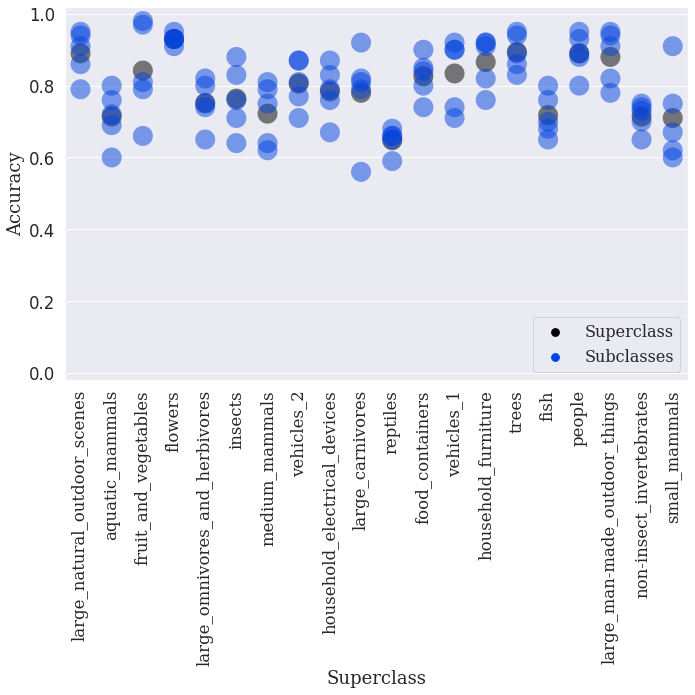

In [93]:
sns.set(font_scale=1.2) 
sns.set_style("whitegrid")
sns.set_style({'font.family':'serif'})

font = font_manager.FontProperties(family='Dejavu Serif',
                                   style='normal', size=16)
plt.rcParams.update({'font.family': 'serif'})

palette = [sns.xkcd_rgb["black"]] + 5*[sns.xkcd_rgb["blue"]]
sns.set(font_scale=1.5)
f = plt.figure(figsize=(10,10))
ax = sns.stripplot(x="Superclass", y="Accuracy", hue="Subset", data=plot_df, jitter=False, s=20, palette=palette, alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontdict={'family':'Dejavu Serif'})
# ax.set_yticklabels(ax.get_yticklabels(),fontdict={'family':'Dejavu Serif'})
ax.set_xlabel(ax.get_xlabel(),fontdict={'family':'Dejavu Serif'})
ax.set_ylabel(ax.get_ylabel(),fontdict={'family':'Dejavu Serif'})
h,l = ax.get_legend_handles_labels()
l[1] = 'Subclasses'
l[0] = 'Superclass'
ax.legend_.remove()
ax.legend(h[0:2],l[0:2], ncol=1, loc='lower right',prop=font)
ax.set_ylim([-0.02,1.02])
plt.tight_layout()
plt.savefig(f'{checkpoint_dir}/Superclass-Subclass-CIFAR-100-Correct-Val-v3.png',format='png')
plt.show()